In [1]:
import numpy as np
import dadi
import random
import pickle
import os, sys
sys.path.append(os.path.join(os.getcwd(), '..')) # this is the ml_dadi dir
import data_manip
from data_manip import generating_data
from mapie.regression import MapieRegressor
from sklearn.neural_network import MLPRegressor
from matplotlib import pyplot as plt
from mapie.metrics import regression_coverage_score

In [2]:
# def generate_data_from_params(n_samples, theta_list):
#     # designate dadi demographic model, sample size, and extrapolation grid
#     func = dadi.Demographics2D.split_mig
#     ns = [20,20]
#     pts_l = [40, 50, 60]
#     logs = [True, True, False, False] # specify param in log scale

#     # generate params
#     params_list = []

#     while len(params_list) < n_samples:
#         # pick random values in specified range
#         nu1 = random.random() * 4 - 2
#         nu2 = random.random() * 4 - 2
#         T = random.random() * 1.9 + 0.1
#         m = random.random() * 9 + 1
#         params_list.append((nu1, nu2, T, m))
    
#     return generating_data(params_list, theta_list, func, ns, pts_l, logs)

In [3]:
train_data = pickle.load(open('data/2d_splitmig/train_data_random_5000_theta1','rb'))
test_data = pickle.load(open('data/2d_splitmig/test_data','rb')) # this probably have 4 thetas, so exclude theta 1, which is the first in the list

In [4]:
# unpack train data set
X_train = [train_data[0][params].data.flatten()
           for params in train_data[0]]

y_train = [params for params in train_data[0]]
# separate each param
nu1_train = [params[0] for params in y_train]
nu2_train = [params[1] for params in y_train]
T_train = [params[2] for params in y_train]
m_train = [params[3] for params in y_train]

In [6]:
# # implementing MAPIE train
# mlpr = MLPRegressor(hidden_layer_sizes=(50,50),
#                             activation='relu', solver='adam',
#                             alpha=0.0001, max_iter=1000)

# # for nu1
# mapie_nu1 = MapieRegressor(mlpr)
# mapie_nu1.fit(X_train, nu1_train)
# # for nu2
# mapie_nu2 = MapieRegressor(mlpr)
# mapie_nu2.fit(X_train, nu2_train)
# # for T
# mapie_T = MapieRegressor(mlpr)
# mapie_T.fit(X_train, T_train)
# # for m
# mapie_m = MapieRegressor(mlpr)
# mapie_m.fit(X_train, m_train)

MapieRegressor(estimator=MLPRegressor(hidden_layer_sizes=(50, 50),
                                      max_iter=1000))

In [26]:
# pickle.dump(mapie_nu1, open('data/2d_splitmig/mapie_nu1', 'wb'), 2)
# pickle.dump(mapie_nu2, open('data/2d_splitmig/mapie_nu2', 'wb'), 2)
# pickle.dump(mapie_T, open('data/2d_splitmig/mapie_T', 'wb'), 2)
# pickle.dump(mapie_m, open('data/2d_splitmig/mapie_m', 'wb'), 2)

In [13]:
mapie_nu1 = pickle.load(open('data/2d_splitmig/mapie_nu1', 'rb'))
mapie_nu2 = pickle.load(open('data/2d_splitmig/mapie_nu2', 'rb'))
mapie_T = pickle.load(open('data/2d_splitmig/mapie_T', 'rb'))
mapie_m = pickle.load(open('data/2d_splitmig/mapie_m', 'rb'))

In [21]:
# unpack test data set
# test_data[i] with i = 1,2,3 depending on theta case
X_test = [test_data[0][params].data.flatten()
          for params in test_data[0]]
y_test = [params for params in test_data[0]]
# separate each param
nu1_test = [params[0] for params in y_test]
nu2_test = [params[1] for params in y_test]
T_test = [params[2] for params in y_test]
m_test = [params[3] for params in y_test]

In [22]:
# implementing MAPIE test
alpha = [0.05, 0.1, 0.2, 0.5, 0.7, 0.85]
# for nu1
nu1_pred, nu1_pis = mapie_nu1.predict(X_test, alpha=alpha)
# for nu2
nu2_pred, nu2_pis = mapie_nu2.predict(X_test, alpha=alpha)
# for T
T_pred, T_pis = mapie_T.predict(X_test, alpha=alpha)
# for m
m_pred, m_pis = mapie_m.predict(X_test, alpha=alpha)

In [23]:
# coverage score by params
nu1_coverage_scores = [
    regression_coverage_score(nu1_test, nu1_pis[:, 0, i], nu1_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]
nu2_coverage_scores = [
    regression_coverage_score(nu2_test, nu2_pis[:, 0, i], nu2_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]
T_coverage_scores = [
    regression_coverage_score(T_test, T_pis[:, 0, i], T_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]
m_coverage_scores = [
    regression_coverage_score(m_test, m_pis[:, 0, i], m_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]

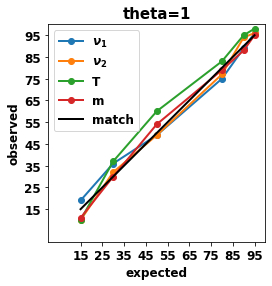

In [25]:
# plot coverage

expected = [95, 90, 80, 50, 30, 15]
theta = 1
params = [r'$ν_1$', r'$ν_2$', 'T', 'm']

observed = ([s*100 for s in nu1_coverage_scores],
            [s*100 for s in nu2_coverage_scores],
            [s*100 for s in T_coverage_scores],
            [s*100 for s in m_coverage_scores],)

fig = plt.figure()
ax = plt.gca()
ax.set_aspect('equal', 'box')
font = {'weight': 'bold', 'size': 12}
plt.rc('font', **font)

ax.set_title(f'theta={theta}', fontsize=15, fontweight='bold')
ax.set_xlabel("expected", fontsize=12, fontweight='bold')
ax.set_ylabel("observed", fontsize=12, fontweight='bold')

for i in range(len(params)):
    ax.plot(expected, observed[i],
            label=params[i], marker='o', linewidth=2)
ax.plot(expected, expected, label='match', linewidth=2, color="black")

plt.xticks(np.arange(min(expected), max(expected)+5, 10))
plt.yticks(np.arange(min(expected), max(expected)+5, 10))
plt.xlim([0, 100])
plt.ylim([0, 100])

ax.legend()


In [26]:
# plot 95% confidence interval
theta = 1
params = params = [r'$ν_1$', r'$ν_2$', 'T', 'm']

nu1_arr = np.array([nu1_test, nu1_pred, nu1_pis[:, 0, 0], nu1_pis[:, 1, 0]]) #nu_test is the true test val

nu2_arr = np.array([nu2_test, nu2_pred, nu2_pis[:, 0, 0], nu2_pis[:, 1, 0]]) 

T_arr = np.array([T_test, T_pred, T_pis[:, 0, 0], T_pis[:, 1, 0]])

m_arr = np.array([m_test, m_pred, m_pis[:, 0, 0], m_pis[:, 1, 0]])

# sort by param
int_arr_all = [nu1_arr.T.tolist(), nu2_arr.T.tolist(), T_arr.T.tolist(), m_arr.T.tolist()] # differs from Connie bootstrapping version: [true, pred, lower, upper]
size = 100
x = range(size)


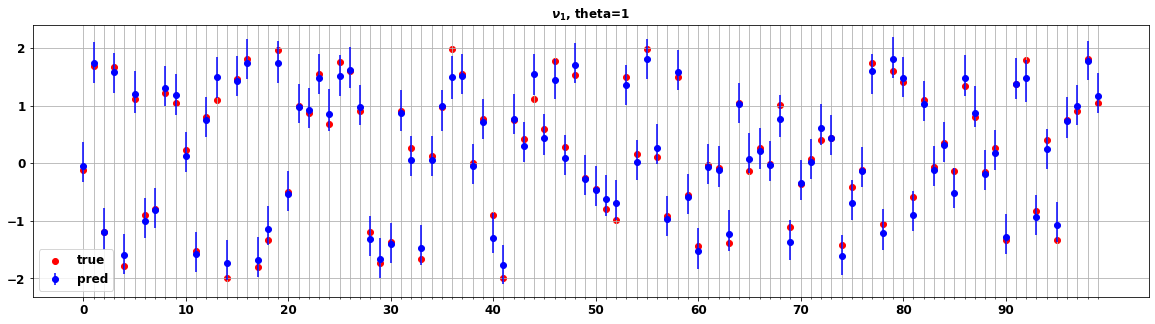

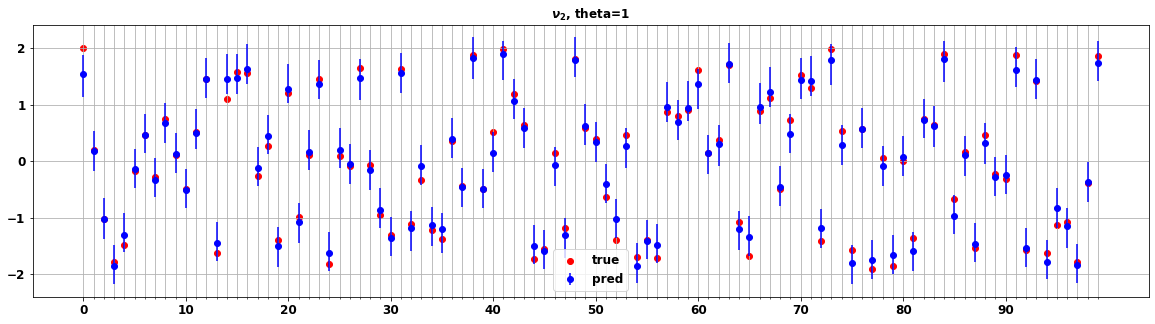

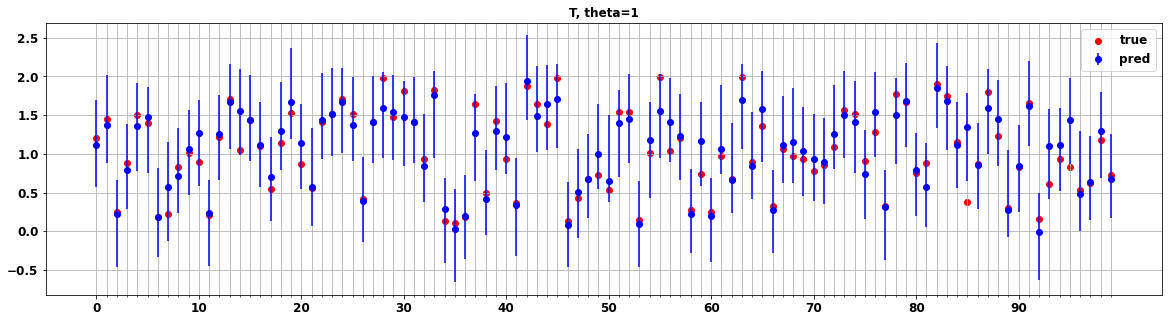

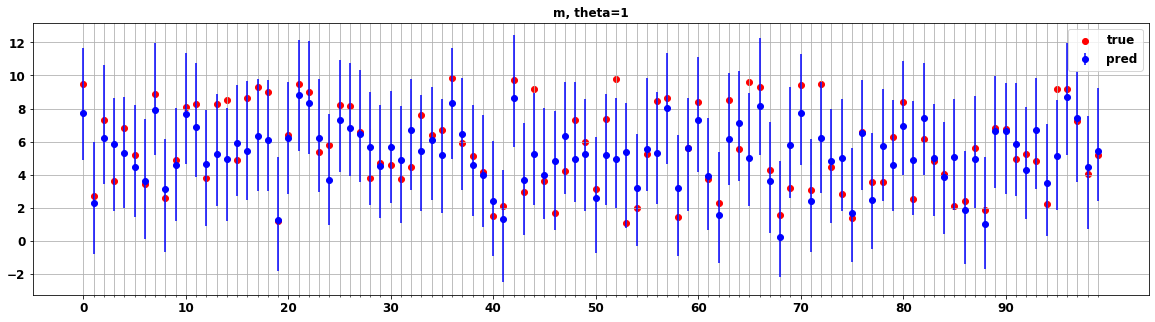

In [27]:
# plot 95% confidence interval (cont.)
for param, int_arr in zip(params, int_arr_all):
    int_arr = np.array(int_arr[:size])
    int_arr = int_arr.transpose(1, 0)

    fig = plt.figure(figsize=(20, 5))
    # ax = fig.add_subplot(1, 1, 1)
    ax = plt.gca()
    minor_ticks = np.arange(0, size)
    major_ticks = np.arange(0, size, 10)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.grid(which='both')

    ax.scatter(x, int_arr[0], c="red", label="true")
    neg_int = int_arr[1] - int_arr[2]
    pos_int = int_arr[3] - int_arr[1]
    ax.errorbar(x, int_arr[1], yerr=[
                neg_int, pos_int], fmt='bo', label = 'pred')

    ax.set_title(f'{param}, theta={theta}', fontsize=12, fontweight='bold')
    ax.legend()